# Horse or Human? In-graph training loop Assignment

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow-Advanced_Techniques_Specialization/blob/master/Custom_and_Distributed_Training_with_TensorFlow/Week3/Labs/C2W3_Assignment.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

This assignment lets you practice how to train a Keras model on the [horses_or_humans](https://www.tensorflow.org/datasets/catalog/horses_or_humans) dataset with the entire training process performed in graph mode.  These steps include:
- loading batches
- calculating gradients
- updating parameters
- calculating validation accuracy
- repeating the loop until convergence

## Setup

Import TensorFlow 2.0:

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from keras import Sequential, layers, Input, optimizers, losses, metrics, Model

2024-08-24 10:27:03.145985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 10:27:03.158668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 10:27:03.162434: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-24 10:27:03.170930: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Prepare the dataset

Load the horses to human dataset, splitting 80% for the training set and 20% for the test set.

In [2]:
splits, info = tfds.load('horses_or_humans', as_supervised=True, with_info=True, split=['train[:80%]', 'train[80%:]', 'test'], data_dir='./data')

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

2024-08-24 10:27:05.436567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2048 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

## Pre-process an image (please complete this section)

You'll define a mapping function that resizes the image to a height of 224 by 224, and normalizes the pixels to the range of 0 to 1.  Note that pixels range from 0 to 255.

- You'll use the following function: [tf.image.resize](https://www.tensorflow.org/api_docs/python/tf/image/resize) and pass in the (height,width) as a tuple (or list).
- To normalize, divide by a floating value so that the pixel range changes from [0,255] to [0,1].

In [4]:
# Create a autograph pre-processing function to resize and normalize an image
### START CODE HERE ###
@tf.function
def map_fn(img, label):
    image_height = 224
    image_width = 224
    ### START CODE HERE ###
    # Resize the image
    img = tf.image.resize(img, size=(image_height, image_width))
    # normalize the image
    img /= 255.0
    ### END CODE HERE
    
    return img, label

In [5]:
## TEST CODE:
test_image, test_label = list(train_examples)[0]
test_result = map_fn(test_image, test_label)

print(test_result[0].shape)
print(test_result[1].shape)

del test_image, test_label, test_result

(224, 224, 3)
()


2024-08-24 10:27:06.202106: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Expected Output:**

```
(224, 224, 3)
()
```

## Apply pre-processing to the datasets (please complete this section)

Apply the following steps to the training_examples:
- Apply the `map_fn` to the training_examples
- Shuffle the training data using `.shuffle(buffer_size=)` and set the buffer size to the number of examples.
- Group these into batches using `.batch()` and set the batch size given by the parameter.

Hint: You can look at how validation_examples and test_examples are pre-processed to get a sense of how to chain together multiple function calls.

In [6]:
# Prepare train dataset by using preprocessing with map_fn, shuffling and batching
def prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, batch_size):
    ### START CODE HERE ###
    train_ds = train_examples.map(map_fn).shuffle(buffer_size=num_examples).batch(batch_size)
    ### END CODE HERE ###
    valid_ds = validation_examples.map(map_fn).batch(batch_size)
    test_ds = test_examples.map(map_fn).batch(batch_size)
    
    return train_ds, valid_ds, test_ds

In [7]:
train_ds, valid_ds, test_ds = prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, BATCH_SIZE)

In [8]:
## TEST CODE:
test_train_ds = list(train_ds)
print(len(test_train_ds))
print(test_train_ds[0][0].shape)

del test_train_ds

26
(32, 224, 224, 3)


2024-08-24 10:27:06.496954: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Expected Output:**

```
26
(32, 224, 224, 3)
```

### Define the model

In [9]:
MODULE_HANDLE = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/feature-vector/1")

model = Sequential([Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
                    layers.Lambda(lambda x: MODULE_HANDLE(x)), # hub.KerasLayer(MODULE_HANDLE),
                    layers.Dense(num_classes, activation='softmax')])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,098 (16.01 KB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 0 (0.00 B)

## Define optimizer: (please complete these sections)
Define the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) that is in the tf.keras.optimizers module.

In [10]:
def set_adam_optimizer():
    ### START CODE HERE ###
    # Define the adam optimizer
    optimizer = optimizers.Adam()
    ### END CODE HERE ###
    
    return optimizer

In [11]:
## TEST CODE:
test_optimizer = set_adam_optimizer()

print(type(test_optimizer))

del test_optimizer

<class 'keras.src.optimizers.adam.Adam'>


**Expected Output:**
```
<class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
```

## Define the loss function (please complete this section)

Define the loss function as the [sparse categorical cross entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) that's in the tf.keras.losses module.  Use the same function for both training and validation.

In [12]:
def set_sparse_cat_crossentropy_loss():
    ### START CODE HERE ###
    # Define object oriented metric of Sparse categorical crossentropy for train and val loss
    train_loss = losses.SparseCategoricalCrossentropy()
    val_loss = losses.SparseCategoricalCrossentropy()
    ### END CODE HERE ###
    
    return train_loss, val_loss

In [13]:
## TEST CODE:
test_train_loss, test_val_loss = set_sparse_cat_crossentropy_loss()

print(type(test_train_loss))
print(type(test_val_loss))

del test_train_loss, test_val_loss

<class 'keras.src.losses.losses.SparseCategoricalCrossentropy'>
<class 'keras.src.losses.losses.SparseCategoricalCrossentropy'>


**Expected Output:**
```
<class 'tensorflow.python.keras.losses.SparseCategoricalCrossentropy'>
<class 'tensorflow.python.keras.losses.SparseCategoricalCrossentropy'>
```

## Define the acccuracy function (please complete this section)
Define the accuracy function as the [spare categorical accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy) that's contained in the tf.keras.metrics module.   Use the same function for both training and validation.

In [14]:
def set_sparse_cat_crossentropy_accuracy():
    ### START CODE HERE ###
    # Define object oriented metric of Sparse categorical accuracy for train and val accuracy
    train_accuracy = metrics.SparseCategoricalAccuracy()
    val_accuracy = metrics.SparseCategoricalAccuracy()
    ### END CODE HERE ###
    
    return train_accuracy, val_accuracy

In [15]:
## TEST CODE:
test_train_accuracy, test_val_accuracy = set_sparse_cat_crossentropy_accuracy()

print(type(test_train_accuracy))
print(type(test_val_accuracy))

del test_train_accuracy, test_val_accuracy

<class 'keras.src.metrics.accuracy_metrics.SparseCategoricalAccuracy'>
<class 'keras.src.metrics.accuracy_metrics.SparseCategoricalAccuracy'>


**Expected Output:**
```
<class 'tensorflow.python.keras.metrics.SparseCategoricalAccuracy'>
<class 'tensorflow.python.keras.metrics.SparseCategoricalAccuracy'>
```

Call the three functions that you defined to set the optimizer, loss and accuracy

In [16]:
optimizer = set_adam_optimizer()
train_loss, val_loss = set_sparse_cat_crossentropy_loss()
train_accuracy, val_accuracy = set_sparse_cat_crossentropy_accuracy()

### Define the training loop (please complete this section)

In the training loop:
- Get the model predictions: use the model, passing in the input `x`
- Get the training loss: Call `train_loss`, passing in the true `y` and the predicted `y`.
- Calculate the gradient of the loss with respect to the model's variables: use `tape.gradient` and pass in the loss and the model's `trainable_variables`.
- Optimize the model variables using the gradients: call `optimizer.apply_gradients` and pass in a `zip()` of the two lists: the gradients and the model's `trainable_variables`.
- Calculate accuracy: Call `train_accuracy`, passing in the true `y` and the predicted `y`.

In [17]:
# This code uses the GPU if available, otherwise uses a CPU
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'
EPOCHS = 2

# Custom training step
def train_one_step(model, optimizer, x, y, train_loss, train_accuracy):
    '''
    Trains on a batch of images for one step.
    
    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        x (Tensor) -- training images
        y (Tensor) -- training labels
        train_loss (keras Loss) -- loss object for training
        train_accuracy (keras Metric) -- accuracy metric for training
    '''

    with tf.GradientTape() as tape:
    ### START CODE HERE ###
        # Run the model on input x to get predictions
        predictions = model(x)
        # Compute the training loss using `train_loss`, passing in the true y and the predicted y
        loss = train_loss(y_true=y, y_pred=predictions)

    # Using the tape and loss, compute the gradients on model variables using tape.gradient
    grads = tape.gradient(loss, model.trainable_variables)
    
    # Zip the gradients and model variables, and then apply the result on the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Call the train accuracy object on ground truth and predictions
    train_accuracy(y_true=y, y_pred=predictions)
    ### END CODE HERE

    return loss

In [18]:
## TEST CODE:
def base_model():
    inputs = Input(shape=(2, 2))
    x = layers.Dense(64, activation='relu')(inputs)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)

    return model

test_model = base_model()

test_optimizer = set_adam_optimizer()
test_image = tf.expand_dims(tf.ones((2, 2)), axis=0)
test_label = tf.expand_dims(tf.ones((1,)), axis=0)
test_train_loss, _ = set_sparse_cat_crossentropy_loss()
test_train_accuracy, _ = set_sparse_cat_crossentropy_accuracy()

test_result = train_one_step(test_model, test_optimizer, test_image, test_label, test_train_loss, test_train_accuracy)
print(test_result)

del test_result, test_model, test_optimizer, test_image, test_label, test_train_loss, test_train_accuracy

tf.Tensor(0.6931472, shape=(), dtype=float32)


**Expected Output:**

You will see a Tensor with the same shape and dtype. The value might be different.

```
tf.Tensor(0.6931472, shape=(), dtype=float32)
```

## Define the 'train' function (please complete this section)

You'll first loop through the training batches to train the model. (Please complete these sections)
- The `train` function will use a for loop to iteratively call the `train_one_step` function that you just defined.
- You'll use `tf.print` to print the step number, loss, and train_accuracy.result() at each step.  Remember to use tf.print when you plan to generate autograph code.

Next, you'll loop through the batches of the validation set to calculation the validation loss and validation accuracy. (This code is provided for you).  At each iteration of the loop:
- Use the model to predict on x, where x is the input from the validation set.
- Use val_loss to calculate the validation loss between the true validation 'y' and predicted y.
- Use val_accuracy to calculate the accuracy of the predicted y compared to the true y.

Finally, you'll print the validation loss and accuracy using tf.print. (Please complete this section)
- print the final `loss`, which is the validation loss calculated by the last loop through the validation dataset.
- Also print the val_accuracy.result().

**HINT**
If you submit your assignment and see this error for your stderr output: 
```
Cannot convert 1e-07 to EagerTensor of dtype int64
```
Please check your calls to train_accuracy and val_accuracy to make sure that you pass in the true and predicted values in the correct order (check the documentation to verify the order of parameters).

In [19]:
# Decorate this function with tf.function to enable autograph on the training loop
@tf.function
def train(model, optimizer, epochs, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    '''
    Performs the entire training loop. Prints the loss and accuracy per step and epoch.
    
    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        epochs (int) -- number of epochs
        train_ds (tf Dataset) -- the train set containing image-label pairs
        train_loss (keras Loss) -- loss function for training
        train_accuracy (keras Metric) -- accuracy metric for training
        valid_ds (Tensor) -- the val set containing image-label pairs
        val_loss (keras Loss) -- loss object for validation
        val_accuracy (keras Metric) -- accuracy metric for validation
    '''

    step = 0
    loss = 0.0
    
    for epoch in range(epochs):
        for x, y in train_ds:
            # Training step number increments at each iteration
            step += 1

            with tf.device(device_name=device):
                ### START CODE HERE ###
                # Run one training step by passing appropriate model parameters
                # required by the function and finally get the loss to report the results
                loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)
                ### END CODE HERE ###

            # Use tf.print to report your results.
            # Print the training step number, loss and accuracy
            tf.print('Step', step, ': train loss', loss, '; train accuracy', train_accuracy.result())

        with tf.device(device_name=device):
            for x, y in valid_ds:
                # Call the model on the batches of inputs x and get the predictions
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)
        
        # Print the validation loss and accuracy
        ### START CODE HERE ###
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())
        ### END CODE HERE ###

Run the `train` function to train your model! You should see the loss generally decreasing and the accuracy increasing.

**Note**: **Please let the training finish before submitting** and **do not** modify the next cell. It is required for grading. This will take around 5 minutes to run. 

In [20]:
train(model, optimizer, EPOCHS, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy)

2024-08-24 10:27:25.723690: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1724516845.777798   14855 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516845.801037   14855 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516845.806232   14855 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516845.814029   14855 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516845.820418   14855 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516845.834075   14855 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516845.847622   14855 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516845.860336   14855 gpu_t

Step 1 : train loss 1.60876155 ; train accuracy 0.1875


W0000 00:00:1724516846.973294   14855 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516846.983267   14855 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516847.015267   14855 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516847.022290   14855 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516847.033700   14855 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516847.039763   14855 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516847.044490   14855 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516847.049947   14855 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516847.054625   14855 gp

Step 2 : train loss 0.939039707 ; train accuracy 0.265625
Step 3 : train loss 0.972150624 ; train accuracy 0.3125
Step 4 : train loss 0.465147674 ; train accuracy 0.4375
Step 5 : train loss 0.475729793 ; train accuracy 0.50625
Step 6 : train loss 0.250091076 ; train accuracy 0.578125
Step 7 : train loss 0.197387397 ; train accuracy 0.633928597
Step 8 : train loss 0.164611176 ; train accuracy 0.67578125
Step 9 : train loss 0.110943645 ; train accuracy 0.708333313
Step 10 : train loss 0.0603829212 ; train accuracy 0.7375
Step 11 : train loss 0.0542604551 ; train accuracy 0.761363626
Step 12 : train loss 0.0412921 ; train accuracy 0.78125
Step 13 : train loss 0.0277740434 ; train accuracy 0.798076928
Step 14 : train loss 0.0282988325 ; train accuracy 0.8125
Step 15 : train loss 0.0236692727 ; train accuracy 0.825
Step 16 : train loss 0.0270147566 ; train accuracy 0.8359375
Step 17 : train loss 0.0246966854 ; train accuracy 0.845588207
Step 18 : train loss 0.0332669 ; train accuracy 0.8541

W0000 00:00:1724516851.787782   14850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516851.791128   14850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516851.794916   14850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516851.799774   14850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516851.803821   14850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516851.809923   14850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516851.818564   14850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516851.824910   14850 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516851.834106   14850 gp

Step 26 : train loss 0.00446792226 ; train accuracy 0.897810221


W0000 00:00:1724516856.172795   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.175344   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.178384   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.181511   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.184316   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.189078   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.194411   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.199217   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.205065   14887 gp

val loss 0.00760996575 ; val accuracy 1


W0000 00:00:1724516856.783614   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.786901   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.790025   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.793690   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.798682   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.801973   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.806139   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.810848   14887 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516856.842136   14887 gp

Step 27 : train loss 0.00554835517 ; train accuracy 0.901639342
Step 28 : train loss 0.00368570955 ; train accuracy 0.905191898
Step 29 : train loss 0.00816259906 ; train accuracy 0.908496737
Step 30 : train loss 0.0019272283 ; train accuracy 0.911578953
Step 31 : train loss 0.00434274552 ; train accuracy 0.914460301
Step 32 : train loss 0.00385134714 ; train accuracy 0.917159736
Step 33 : train loss 0.00399000803 ; train accuracy 0.919694066
Step 34 : train loss 0.00372975366 ; train accuracy 0.922077894
Step 35 : train loss 0.00326378783 ; train accuracy 0.924324334
Step 36 : train loss 0.00490162801 ; train accuracy 0.926444829
Step 37 : train loss 0.00208638608 ; train accuracy 0.92844975
Step 38 : train loss 0.00697372388 ; train accuracy 0.930348277
Step 39 : train loss 0.00559272803 ; train accuracy 0.932148635
Step 40 : train loss 0.0020117159 ; train accuracy 0.933858275
Step 41 : train loss 0.00296851387 ; train accuracy 0.935483873
Step 42 : train loss 0.00197103736 ; train 

# Evaluation

You can now see how your model performs on test images. First, let's load the test dataset and generate predictions:

In [21]:
test_imgs = []
test_labels = []

predictions = []
with tf.device(device_name=device):
    for images, labels in test_ds:
        preds = model(images)
        preds = preds.numpy()
        predictions.extend(preds)

        test_imgs.extend(images.numpy())
        test_labels.extend(labels.numpy())

W0000 00:00:1724516872.474894   14559 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516872.479393   14559 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516872.483322   14559 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516872.486015   14559 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516872.488616   14559 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516872.491668   14559 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516872.495458   14559 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516872.499444   14559 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724516872.502771   14559 gp

Let's define a utility function for plotting an image and its prediction.

In [22]:
# Utilities for plotting
class_names = ['horse', 'human']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    
    # Green-colored annotations will mark correct predictions. red otherwise.
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    # Print the true label first
    print("True label:", true_label)
  
    # Show the image and overlay the prediction
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)

### Plot the result of a single image

Choose an index and display the model's prediction for that image.

True label: 0


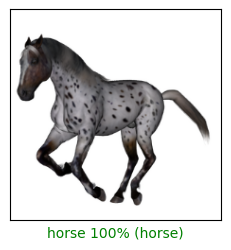

In [23]:
# Visualize the outputs 

# You can modify the index value here from 0 to 255 to test different images
index = 8
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

In [24]:
!rm -rf ./data